In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [6]:
pd.set_option('display.max_columns', None)

Какую метрику использовать?

Будем использовать Root MSE (RMSE). Введение логарифмов означает, что ошибки в прогнозировании дорогих и дешевых домов одинаково повлияют на результат.

In [683]:
TARGET_COL = 'SalePrice'
ID_COL = 'Id'
CAT_COLS = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour',  'Alley',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',  'Heating', 
       'Electrical',  'Functional', 'GarageType', 'SaleType', 'SaleCondition', 'MiscFeature',
       'PavedDrive', 'Street', ] # как обычные cat
RATE_CAT_COLS = ['FireplaceQu', 'KitchenQual', 'ExterQual', 
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 'HeatingQC',  'GarageFinish','GarageQual', 'GarageCond', 'PoolQC', 'Fence'] # заменить на рейтинг потом normalize 
RATE_COLS = ['OverallQual', 'OverallCond'] # потом normalize
DATE_COLS = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'] # пока никак, но можно подумать
BIN_COL = 'CentralAir' # y n -> 1 0
DISCRETE_COLS = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
              'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'] # потом normalize 
REAL_COLS = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
       'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 
       '1stFlrSF', 'GrLivArea', '2ndFlrSF', 'LowQualFinSF'] # к int8, потом normalize

NAN_COLS = ['Alley', 'MiscFeature', 'PoolQC', 'Fence']

Как убирать NaN:
* LotFrontage -> 0 [REAL_COLS]
* MasVnrType -> самым частым [CAT_COLS]
* MasVnrArea -> 0 [REAL_COLS]
* Electrical -> самым частым [CAT_COLS]
* Alley - Na -> нет аллеи -> NAl -> 0 [CAT_COLS]
* BsmtQual - Na -> нет подвала -> NB -> 0 [RATE_COL]
* BsmtCond - Na -> нет подвала -> NB -> 0 [RATE_COLS]
* BsmtExposure - Na -> нет подвала -> NB -> 0 [RATE_COLS]
* BsmtFinType1 - Na -> нет подвала -> NB -> 0 [RATE_COLS]
* BsmtFinType2 - Na -> нет подвала -> NB -> 0 [RATE_COLS]
* FireplaceQu - Na -> нет камина -> NF -> 0 [RATE_COLS]
* GarageType - Na -> нет гаража -> NG -> 0 [CAT_COLS]
* GarageYrBlt - Na -> нет гаража -> NG -> 0 [DATE_COLS]
* GarageFinish - Na -> нет гаража -> NG -> 0 [RATE_COLS]
* GarageQual - Na -> нет гаража -> NG -> 0 [RATE_COLS]
* GarageCond - Na -> нет гаража -> NG -> 0 [RATE_COLS]
* PoolQC - Na -> нет бассейна -> NP -> 0 [RATE_COLS]
* Fence - Na -> нет забора -> NF -> 0 [RATE_COLS]
* MiscFeature - Na -> нет фичей -> NMF -> 0 [RATE_COLS]


Сначала для простоты заполним всё нулями

In [726]:
raw_path = '../data/raw/'
train = pd.read_csv(os.path.join(raw_path, 'train.csv'))
test = pd.read_csv(os.path.join(raw_path, 'test.csv'))

In [685]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [686]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Что сделать?
* убрать id в index - есть
* убрать колонки с большим колвом Nan - есть
* заменить Nan
* cast types
* разделить train и target

In [727]:
def set_idx(df: pd.DataFrame, idx_col: str) -> pd.DataFrame:
    df = df.set_index(idx_col)
    return df

In [728]:
def process_binary(df: pd.DataFrame) -> pd.DataFrame:
    df[BIN_COL] = df[BIN_COL].map(dict(Y=1, N=0))
    return df

In [729]:
def replace_nans(df: pd.DataFrame) -> pd.DataFrame:
    df = df.fillna(0)
    return df

In [730]:
def process_rate_cat_cols(df: pd.DataFrame) -> pd.DataFrame:
    df[['FireplaceQu', 'KitchenQual', 'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond', 'HeatingQC', 'GarageQual', 'GarageCond', 'PoolQC']] \
    = df[['FireplaceQu', 'KitchenQual', 'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond', 'HeatingQC', 'GarageQual', 'GarageCond', 'PoolQC']] \
        .replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    df[['BsmtExposure']] = df[['BsmtExposure']].replace(['Gd', 'Av', 'Mn', 'No'], [4,3,2,1])
    df[['BsmtFinType1', 'BsmtFinType2']] = df[['BsmtFinType1', 'BsmtFinType2']].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'], [6,5,4,3,2,1])
    df[['GarageFinish']] = df[['GarageFinish']].replace(['Fin', 'RFn', 'Unf'], [3,2,1])
    df['Fence'] = df[['Fence']].replace(['GdPrv', 'MnPrv', 'GdWo', 'MnWw'], [2, 1, 2, 1])

    return df

In [731]:
def cast_types(df: pd.DataFrame) -> pd.DataFrame:
    df[CAT_COLS] = df[CAT_COLS].astype('category') # +
    df[RATE_CAT_COLS] = df[RATE_CAT_COLS].astype(np.int32) # +
    df[RATE_COLS] = df[RATE_COLS].astype(np.int32) # +
    df[DATE_COLS] = df[DATE_COLS].astype(np.int32) # +
    df[BIN_COL] = df[BIN_COL].astype(np.int32) # +
    df[DISCRETE_COLS] = df[DISCRETE_COLS].astype(np.int32) # +
    df[REAL_COLS] = df[REAL_COLS].astype(np.int32)
    
    return df

In [732]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = set_idx(df, ID_COL)
    df = process_binary(df)
    df = replace_nans(df)
    df = process_rate_cat_cols(df)
    df = cast_types(df)
    return df

In [733]:
train, target = train.drop(TARGET_COL, axis=1), train[TARGET_COL]

In [734]:
train = preprocess(train)
test = preprocess(test)

In [695]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003,2,2,548,3,3,Y,0,61,0,0,0,0,0,0,0,0,2,2008,WD,Normal
2,20,RL,80,9600,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976,2,2,460,3,3,Y,298,0,0,0,0,0,0,0,0,0,5,2007,WD,Normal
3,60,RL,68,11250,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001,2,2,608,3,3,Y,0,42,0,0,0,0,0,0,0,0,9,2008,WD,Normal
4,70,RL,60,9550,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998,1,3,642,3,3,Y,0,35,272,0,0,0,0,0,0,0,2,2006,WD,Abnorml
5,60,RL,84,14260,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000,2,3,836,3,3,Y,192,84,0,0,0,0,0,0,0,0,12,2008,WD,Normal


<AxesSubplot:>

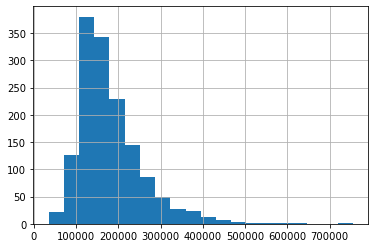

In [162]:
target.hist(bins=20)

## CatBoost modeling

Попробуем обучить CatBoost без обработки признаков

In [163]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [164]:
kf = KFold(n_splits=5)

In [167]:
rmse_cv = []
for train_index, val_index in kf.split(train, target):
    X_train, y_train = train.iloc[train_index], target.iloc[train_index]
    X_val, y_val = train.iloc[val_index], target.iloc[val_index]

    model = CatBoostRegressor(
            learning_rate=0.01,
            early_stopping_rounds=200,
            verbose=100,
            eval_metric='RMSE',
            )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=CAT_COLS)
    y_pred = model.predict(X_val)
    rmse_cv.append(mean_squared_error(y_val, y_pred, squared=False))
                

0:	learn: 80109.4596784	test: 73892.5693571	best: 73892.5693571 (0)	total: 31.5ms	remaining: 31.5s
100:	learn: 47107.8665431	test: 43003.2053182	best: 43003.2053182 (100)	total: 3.32s	remaining: 29.6s
200:	learn: 32661.5051299	test: 31579.5844412	best: 31579.5844412 (200)	total: 6.43s	remaining: 25.6s
300:	learn: 26126.2044483	test: 27447.7551787	best: 27447.7551787 (300)	total: 9.63s	remaining: 22.4s
400:	learn: 22834.1999618	test: 25788.7842281	best: 25788.7842281 (400)	total: 12.9s	remaining: 19.3s
500:	learn: 20700.2419057	test: 24833.0717181	best: 24828.8641667 (498)	total: 16.3s	remaining: 16.2s
600:	learn: 19273.4537866	test: 24144.5926738	best: 24144.5926738 (600)	total: 19.9s	remaining: 13.2s
700:	learn: 18167.8500916	test: 23717.6674236	best: 23717.6674236 (700)	total: 23.5s	remaining: 10s
800:	learn: 17330.0749183	test: 23369.2672958	best: 23369.2672958 (800)	total: 26.8s	remaining: 6.65s
900:	learn: 16573.5810608	test: 23084.0210345	best: 23084.0210345 (900)	total: 30.5s	re

In [168]:
from statistics import mean

In [169]:
mean(rmse_cv)

25936.43252289058

Ошибка очень большая. Попробуем поработать с подбором признаков

### Подбор признаков

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from matplotlib import pyplot

In [742]:
X_train, X_val, y_train, y_val = train_test_split(train, target, train_size=0.8, random_state=42)
X_train.shape, X_val.shape

((1168, 79), (292, 79))

In [260]:
def select_features(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [215]:
int_cols = train.select_dtypes(np.int32).columns

In [227]:
X_train_fs, X_val_fs, fs = select_features(X_train[int_cols].astype(np.float32), y_train, X_val[int_cols].astype(np.float32))

In [225]:
X_train.shape, X_train_fs.shape

((1168, 79), (1168, 52))

Feature 0: 7.999849
Feature 1: 62.881674
Feature 2: 88.026396
Feature 3: 1988.934336
Feature 4: 7.104004
Feature 5: 465.541255
Feature 6: 441.269761
Feature 7: 350.075948
Feature 8: 1078.528091
Feature 9: 0.205168
Feature 10: 610.626913
Feature 11: 53.898216
Feature 12: 173.836266
Feature 13: 118.285725
Feature 14: 209.903749
Feature 15: 0.032694
Feature 16: 0.000501
Feature 17: 59.352530
Feature 18: 804.855898
Feature 19: 284.484255
Feature 20: 81.363400
Feature 21: 714.074352
Feature 22: 140.509206
Feature 23: 1.043717
Feature 24: 1343.916561
Feature 25: 60.385991
Feature 26: 0.713372
Feature 27: 554.155545
Feature 28: 114.375094
Feature 29: 38.206365
Feature 30: 21.321637
Feature 31: 936.709903
Feature 32: 545.921312
Feature 33: 316.490362
Feature 34: 458.004038
Feature 35: 86.819731
Feature 36: 503.717006
Feature 37: 871.552691
Feature 38: 809.123613
Feature 39: 94.459435
Feature 40: 82.827018
Feature 41: 134.472011
Feature 42: 139.842363
Feature 43: 15.915252
Feature 44: 0.155110


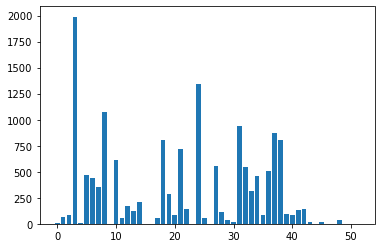

In [226]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Важное количество числовых признаков +- равно 20

In [743]:
def select_features(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k=20)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	cols = fs.get_support(indices=True)
	X_train_fs = X_train.iloc[:,cols]
	X_test_fs = X_test.iloc[:,cols]
	# transform train input data
	# X_train_fs = fs.transform(X_train)
	# transform test input data
	# X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [744]:
X_train_fs, X_val_fs, fs = select_features(X_train[int_cols].astype(np.float32), y_train, X_val[int_cols].astype(np.float32))

In [745]:
fs.get_support(indices=True)

array([ 2,  4,  5,  6,  7,  9, 11, 13, 17, 18, 20, 23, 26, 30, 31, 32, 33,
       35, 36, 37], dtype=int64)

In [746]:
X_train_fs.shape, X_val_fs.shape

((1168, 20), (292, 20))

In [747]:
X_train_fs.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars',
       'GarageArea'],
      dtype='object')

In [740]:
X_train_fs = X_train_fs.merge(X_train[CAT_COLS], left_index=True, right_index=True)
X_val_fs = X_val_fs.merge(X_val[CAT_COLS], left_index=True, right_index=True)

In [741]:
X_train_fs.shape

(1168, 48)

In [238]:
X_train_fs

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,MSZoning,LotShape,LandContour,Alley,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,Functional,GarageType,SaleType,SaleCondition,MiscFeature,PavedDrive,Street
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7.0,2003.0,2003.0,196.0,4.0,4.0,1.0,706.0,856.0,5.0,856.0,1710.0,2.0,4.0,8.0,0.0,0.0,2.0,2.0,548.0,RL,Reg,Lvl,0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
2,6.0,1976.0,1976.0,0.0,3.0,4.0,4.0,978.0,1262.0,5.0,1262.0,1262.0,2.0,3.0,6.0,1.0,3.0,2.0,2.0,460.0,RL,Reg,Lvl,0,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
3,7.0,2001.0,2002.0,162.0,4.0,4.0,2.0,486.0,920.0,5.0,920.0,1786.0,2.0,4.0,6.0,1.0,3.0,2.0,2.0,608.0,RL,IR1,Lvl,0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
4,7.0,1915.0,1970.0,0.0,3.0,3.0,1.0,216.0,756.0,4.0,961.0,1717.0,1.0,4.0,7.0,1.0,4.0,1.0,3.0,642.0,RL,IR1,Lvl,0,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,SBrkr,Typ,Detchd,WD,Abnorml,0,Y,Pave
5,8.0,2000.0,2000.0,350.0,4.0,4.0,3.0,655.0,1145.0,5.0,1145.0,2198.0,2.0,4.0,9.0,1.0,3.0,2.0,3.0,836.0,RL,IR1,Lvl,0,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,4.0,1969.0,1969.0,0.0,3.0,4.0,3.0,1198.0,1198.0,3.0,1258.0,1258.0,0.0,3.0,6.0,0.0,0.0,1.0,2.0,400.0,RL,Reg,Lvl,0,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,Duplex,SFoyer,Gable,CompShg,Plywood,Plywood,None,CBlock,GasA,SBrkr,Typ,CarPort,WD,Alloca,0,Y,Pave
1165,5.0,1978.0,1978.0,0.0,3.0,4.0,4.0,680.0,1360.0,5.0,1432.0,1432.0,1.0,4.0,5.0,1.0,3.0,1.0,2.0,588.0,RL,IR1,Lvl,0,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,SLvl,Gable,CompShg,Plywood,Plywood,None,PConc,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
1166,7.0,2009.0,2009.0,268.0,4.0,4.0,1.0,0.0,1502.0,5.0,1502.0,1502.0,2.0,4.0,7.0,0.0,0.0,2.0,2.0,644.0,RL,IR1,Lvl,0,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,Stone,PConc,GasA,SBrkr,Typ,Attchd,New,Partial,0,Y,Pave


In [245]:
selected_cols_20 = X_train_fs.columns

In [246]:
selected_cols_20.shape

(47,)

Снова обучим CatBoost

In [275]:
kf = KFold(n_splits=5)

rmse_cv = []
for train_index, val_index in kf.split(train, target):
    X_train, y_train = train[selected_cols_20].iloc[train_index], target.iloc[train_index]
    X_val, y_val = train[selected_cols_20].iloc[val_index], target.iloc[val_index]

    model = CatBoostRegressor(iterations = 10000,
                        verbose = 1000,
                        learning_rate = 0.08,
                        eval_metric = 'RMSE',
                        random_seed = 42,
                        # logging_level = 'Silent',
                        use_best_model = True,
                        loss_function = 'RMSE',
                        od_type = 'Iter',
                        od_wait = 1000,
                        one_hot_max_size = 20,
                        l2_leaf_reg = 100,
                        depth = 3,
                        rsm = 0.6,
                        random_strength = 2,
                        bagging_temperature = 10)

    '''model = CatBoostRegressor(
            learning_rate=0.01,
            iterations=2000,
            early_stopping_rounds=200,
            verbose=200,
            eval_metric='RMSE',
            )'''



    model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=CAT_COLS)
    y_pred = model.predict(X_val)
    rmse_cv.append(mean_squared_error(y_val, y_pred, squared=False))

0:	learn: 78508.2342444	test: 72251.0399310	best: 72251.0399310 (0)	total: 1.87ms	remaining: 18.7s
1000:	learn: 22114.8605080	test: 24785.1837298	best: 24785.1837298 (1000)	total: 7.3s	remaining: 1m 5s
2000:	learn: 18235.0490606	test: 23693.1391922	best: 23685.9313709 (1994)	total: 14.5s	remaining: 58.1s
3000:	learn: 16028.3870840	test: 23475.6662391	best: 23422.4129076 (2626)	total: 21.4s	remaining: 49.9s
4000:	learn: 14616.8350797	test: 23440.7983359	best: 23390.4606117 (3465)	total: 28.4s	remaining: 42.6s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 23390.46061
bestIteration = 3465

Shrink model to first 3466 iterations.
0:	learn: 77184.1883913	test: 79243.9902015	best: 79243.9902015 (0)	total: 1.33ms	remaining: 13.3s
1000:	learn: 21299.9280811	test: 33153.1172719	best: 32701.7486628 (188)	total: 7.1s	remaining: 1m 3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 32701.74866
bestIteration = 188

Shrink model to first 189 iterations.
0:	le

In [276]:
mean(rmse_cv)

25848.166764425056

Попробуем сделать submit на kaggle

In [278]:
model = CatBoostRegressor(iterations = 10000,
                        verbose = 1000,
                        learning_rate = 0.08,
                        eval_metric = 'RMSE',
                        random_seed = 42,
                        # logging_level = 'Silent',
                        use_best_model = True,
                        loss_function = 'RMSE',
                        od_type = 'Iter',
                        od_wait = 1000,
                        one_hot_max_size = 20,
                        l2_leaf_reg = 100,
                        depth = 3,
                        rsm = 0.6,
                        random_strength = 2,
                        bagging_temperature = 10)

In [279]:
model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=CAT_COLS)
y_pred = model.predict(test)

0:	learn: 75153.8135522	test: 85353.9104018	best: 85353.9104018 (0)	total: 8.3ms	remaining: 1m 22s
1000:	learn: 20781.5860313	test: 27914.4467801	best: 27914.4467801 (1000)	total: 8.02s	remaining: 1m 12s
2000:	learn: 17154.6391725	test: 26371.5376111	best: 26365.9228787 (1997)	total: 17s	remaining: 1m 8s
3000:	learn: 14530.9574410	test: 25752.3336639	best: 25752.3336639 (3000)	total: 25.4s	remaining: 59.3s
4000:	learn: 12849.2635657	test: 25407.7852430	best: 25395.7739784 (3877)	total: 33.2s	remaining: 49.7s
5000:	learn: 11530.9406702	test: 25280.9528089	best: 25279.4827981 (4820)	total: 41.3s	remaining: 41.3s
6000:	learn: 10503.7047534	test: 25238.8389836	best: 25233.0586615 (5652)	total: 49.1s	remaining: 32.7s
7000:	learn: 9618.0976430	test: 25239.9949538	best: 25217.1843128 (6163)	total: 56.9s	remaining: 24.4s
8000:	learn: 8813.2891781	test: 25204.2008311	best: 25200.8126940 (7974)	total: 1m 4s	remaining: 16.2s
9000:	learn: 8171.8700223	test: 25216.6685077	best: 25191.7019764 (8174)

In [282]:
pred=pd.DataFrame(y_pred)
sub_df=pd.read_csv(r'C:\Users\User\Desktop\Ivanov_lab2\data\raw\sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred], axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

Особо улучшить результат не удалось. Попробуем еще поработать с признаками

Score на kaggle - 0.12542

In [283]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003,2,2,548,3,3,Y,0,61,0,0,0,0,0,0,0,0,2,2008,WD,Normal
2,20,RL,80,9600,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976,2,2,460,3,3,Y,298,0,0,0,0,0,0,0,0,0,5,2007,WD,Normal
3,60,RL,68,11250,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001,2,2,608,3,3,Y,0,42,0,0,0,0,0,0,0,0,9,2008,WD,Normal
4,70,RL,60,9550,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998,1,3,642,3,3,Y,0,35,272,0,0,0,0,0,0,0,2,2006,WD,Abnorml
5,60,RL,84,14260,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000,2,3,836,3,3,Y,192,84,0,0,0,0,0,0,0,0,12,2008,WD,Normal


In [284]:
train.shape

(1460, 79)

Уберем колонки с большим количеством NAN или с большим количеством одинаковых значений. Затем применим SelectFeatures

In [380]:
# NAN_COLS = ['Alley', 'MiscFeature', 'PoolQC', 'Fence']
useless_cols = []

In [381]:
for col in train.columns:
    if (train[col].value_counts().iloc[0] / train.shape[0]) > 0.8:
        # print(train[col].value_counts())
        useless_cols.append(col)

In [382]:
len(useless_cols)

33

In [383]:
train = train.drop(useless_cols, axis=1)
test = test.drop(useless_cols, axis=1)

In [384]:
def select_features(df: pd.DataFrame, target: pd.Series):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k=20)
	# learn relationship from training data
	fs.fit(df, target)
	cols = fs.get_support(indices=True)
	df_fs = df.iloc[:,cols]
	# transform train input data
	# X_train_fs = fs.transform(X_train)
	# transform test input data
	# X_test_fs = fs.transform(X_test)
	return df_fs, fs

In [385]:
int_cols = train.select_dtypes(np.int32).columns

In [387]:
train_fs, fs = select_features(train[int_cols].astype(np.float32), target)
train_fs.shape

(1460, 20)

In [389]:
cat_cols = train.select_dtypes('category').columns

In [390]:
train_fs = train_fs.merge(train[cat_cols], left_index=True, right_index=True)

In [392]:
train_fs.shape

(1460, 32)

Обучим catboost

In [395]:
X_train, X_val, y_train, y_val = train_test_split(train_fs, target, train_size=0.8, random_state=42)
X_train.shape, X_val.shape

((1168, 32), (292, 32))

In [401]:
model = CatBoostRegressor(iterations = 10000,
                        verbose = 1000,
                        learning_rate = 0.08,
                        eval_metric = 'RMSE',
                        random_seed = 42,
                        # logging_level = 'Silent',
                        use_best_model = True,
                        loss_function = 'RMSE',
                        od_type = 'Iter',
                        od_wait = 1000,
                        one_hot_max_size = 20,
                        l2_leaf_reg = 100,
                        depth = 3,
                        rsm = 0.6,
                        random_strength = 2,
                        bagging_temperature = 10)

In [405]:
model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=list(cat_cols))
y_pred = model.predict(test[train_fs.columns])

0:	learn: 76712.2296134	test: 87071.4714501	best: 87071.4714501 (0)	total: 22.6ms	remaining: 45.2s
200:	learn: 31980.4413287	test: 39499.5164174	best: 39499.5164174 (200)	total: 5.45s	remaining: 48.8s
400:	learn: 23031.3480788	test: 30969.7102525	best: 30969.7102525 (400)	total: 10.8s	remaining: 43s
600:	learn: 19801.4452020	test: 28558.5762287	best: 28558.5762287 (600)	total: 16s	remaining: 37.2s
800:	learn: 18004.1715086	test: 27674.4749792	best: 27674.4749792 (800)	total: 21.3s	remaining: 31.9s
1000:	learn: 16696.5944999	test: 27242.9594740	best: 27242.9594740 (1000)	total: 26.6s	remaining: 26.5s
1200:	learn: 15709.9808101	test: 26968.1003209	best: 26967.9026943 (1187)	total: 31.9s	remaining: 21.2s
1400:	learn: 14900.6700897	test: 26778.3782150	best: 26777.4836579 (1399)	total: 37.2s	remaining: 15.9s
1600:	learn: 14180.8359132	test: 26664.2291184	best: 26662.0676942 (1599)	total: 42.5s	remaining: 10.6s
1800:	learn: 13540.0777596	test: 26567.6119984	best: 26567.6119984 (1800)	total: 

In [406]:
pred=pd.DataFrame(y_pred)
sub_df=pd.read_csv(r'C:\Users\User\Desktop\Ivanov_lab2\data\raw\sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred], axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

Получился score: 0.12947 - несколько хуже

Таким образом, лучший score показал catboost(iterations = 10000,
                        verbose = 1000,
                        learning_rate = 0.08,
                        eval_metric = 'RMSE',
                        random_seed = 42,
                        # logging_level = 'Silent',
                        use_best_model = True,
                        loss_function = 'RMSE',
                        od_type = 'Iter',
                        od_wait = 1000,
                        one_hot_max_size = 20,
                        l2_leaf_reg = 100,
                        depth = 3,
                        rsm = 0.6,
                        random_strength = 2,
                        bagging_temperature = 10) с FeatureSelection

## Попробуем обучить SVR

И используем feature selection

In [698]:
train.shape

(1460, 79)

In [660]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [703]:
def select_features(df: pd.DataFrame, target: pd.Series):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k=20)
	# learn relationship from training data
	fs.fit(df, target)
	cols = fs.get_support(indices=True)
	df_fs = df.iloc[:,cols]
	# transform train input data
	# X_train_fs = fs.transform(X_train)
	# transform test input data
	# X_test_fs = fs.transform(X_test)
	return df_fs, fs

In [704]:
def one_hot_encode(df: pd.DataFrame, ohe: OneHotEncoder) -> pd.DataFrame: 
    # df.info()
    ohe_df = pd.DataFrame(ohe.transform(df[cat_cols].astype(str)), index=df.index)
    ohe_df = ohe_df.astype(np.int8)
    df = df.merge(ohe_df, left_index=True, right_index=True)
    df = df.drop(cat_cols, axis=1)
    return df

In [705]:
def normalize_real_cols(df: pd.DataFrame, scaler: MinMaxScaler) -> pd.DataFrame:
    x_scaled = scaler.transform(df[real_cols])
    
    scaled_cols = pd.DataFrame(x_scaled, index=df.index)
    # print(scaled_cols.head())
    df = df.merge(scaled_cols, left_index=True, right_index=True)
    # print(df.head())
    df = df.drop(real_cols, axis=1)
    return df

In [706]:
int_cols = train.select_dtypes(np.int32).columns
cat_cols = train.select_dtypes('category').columns

In [722]:
CAT_COLS == list(cat_cols)

False

In [707]:
train_fs, fs = select_features(train[int_cols].astype(np.float32), target)
train_fs = train_fs.merge(train[cat_cols], left_index=True, right_index=True)

In [671]:
X_train, X_val, y_train, y_val = train_test_split(train_fs, target, train_size=0.8, random_state=42)

In [673]:
svr_train_cols = X_train.columns

In [667]:
real_cols = train_fs.select_dtypes(np.float32).columns

In [674]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(X_train[cat_cols].astype(str))
scaler = MinMaxScaler().fit(X_train[real_cols])

In [677]:
X_train = one_hot_encode(X_train, ohe)
X_val = one_hot_encode(X_val, ohe)
test = one_hot_encode(test[svr_train_cols], ohe)
X_train = normalize_real_cols(X_train, scaler)
X_val = normalize_real_cols(X_val, scaler)
test = normalize_real_cols(test, scaler)

In [678]:
X_train.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
255,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.444444,0.615942,0.116669,0.000000,0.333333,0.6,0.25,0.163359,0.215057,0.50,0.224874,0.184627,0.333333,0.333333,0.250000,0.000000,0.0,0.666667,0.25,0.207334
1067,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.555556,0.876811,0.733334,0.000000,0.666667,0.8,0.25,0.000000,0.130769,0.75,0.106700,0.233044,0.666667,0.333333,0.416667,0.333333,0.6,0.666667,0.50,0.267983
639,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.444444,0.275362,0.000000,0.000000,0.333333,0.4,0.25,0.000000,0.130278,0.75,0.106012,0.087038,0.333333,0.333333,0.166667,0.000000,0.0,0.000000,0.00,0.000000
800,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.444444,0.471014,0.000000,0.182874,0.333333,0.8,0.25,0.100815,0.119640,1.00,0.148463,0.270158,0.333333,0.666667,0.416667,0.666667,0.6,0.333333,0.25,0.169252
381,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.444444,0.376811,0.000000,0.000000,0.333333,0.6,0.25,0.038625,0.167921,0.50,0.158788,0.255652,0.666667,0.666667,0.333333,0.333333,0.8,0.333333,0.25,0.217207


In [679]:
from sklearn.svm import SVR

In [680]:
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_val)
print(mean_squared_error(y_val, y_pred, squared=False))

88639.55698574694


In [681]:
test_pred = svr.predict(test)

In [682]:
pred=pd.DataFrame(test_pred)
sub_df=pd.read_csv(r'C:\Users\User\Desktop\Ivanov_lab2\data\raw\sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred], axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

На test выборке получилось Score: 0.41612. SVR работает явно хуже, чем CatBoost. Выбираем CatBoost

In [751]:
train = pd.read_pickle(r'C:\Users\User\Desktop\Ivanov_lab2\data\processed\train.pkl')

In [752]:
train.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,MSSubClass,MSZoning,LotShape,LandContour,Alley,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,Functional,GarageType,SaleType,SaleCondition,MiscFeature,PavedDrive,Street
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7,2003,2003,196,4,4,1,706,856,5,856,1710,2,4,8,0,0,2,2,548,60,RL,Reg,Lvl,0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
2,6,1976,1976,0,3,4,4,978,1262,5,1262,1262,2,3,6,1,3,2,2,460,20,RL,Reg,Lvl,0,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
3,7,2001,2002,162,4,4,2,486,920,5,920,1786,2,4,6,1,3,2,2,608,60,RL,IR1,Lvl,0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave
4,7,1915,1970,0,3,3,1,216,756,4,961,1717,1,4,7,1,4,1,3,642,70,RL,IR1,Lvl,0,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,SBrkr,Typ,Detchd,WD,Abnorml,0,Y,Pave
5,8,2000,2000,350,4,4,3,655,1145,5,1145,2198,2,4,9,1,3,2,3,836,60,RL,IR1,Lvl,0,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,WD,Normal,0,Y,Pave


In [749]:
train.shape

(1460, 48)

In [753]:
X_train, X_val, y_train, y_val = train_test_split(train, target, train_size=0.8, random_state=42)

In [757]:
model = CatBoostRegressor(iterations = 10000,
                        verbose = 1000,
                        learning_rate = 0.03,
                        eval_metric = 'RMSE',
                        random_seed = 42,
                        # logging_level = 'Silent',
                        use_best_model = True,
                        loss_function = 'RMSE',
                        od_type = 'Iter',
                        od_wait = 2000,
                        one_hot_max_size = 20,
                        l2_leaf_reg = 100,
                        depth = 3,
                        rsm = 0.6,
                        random_strength = 2,
                        bagging_temperature = 10)

model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=CAT_COLS)

0:	learn: 76430.6293259	test: 86813.2495769	best: 86813.2495769 (0)	total: 2.02ms	remaining: 20.2s
1000:	learn: 23396.3030533	test: 29896.9224656	best: 29896.9224656 (1000)	total: 7.67s	remaining: 1m 8s
2000:	learn: 20740.5951892	test: 27913.3098781	best: 27913.2405021 (1998)	total: 15.1s	remaining: 1m
3000:	learn: 18791.1230727	test: 26932.6262856	best: 26932.0822822 (2999)	total: 22.7s	remaining: 53s
4000:	learn: 17353.9739320	test: 26344.2655996	best: 26342.5824708 (3975)	total: 30.1s	remaining: 45.1s
5000:	learn: 16393.4147592	test: 25998.9879909	best: 25995.9435912 (4972)	total: 37.4s	remaining: 37.4s
6000:	learn: 15695.2154298	test: 25745.4926244	best: 25745.1711123 (5999)	total: 44.8s	remaining: 29.9s
7000:	learn: 15054.7080111	test: 25618.5482536	best: 25618.3374934 (6998)	total: 53s	remaining: 22.7s
8000:	learn: 14517.0023830	test: 25535.6396097	best: 25532.9803219 (7972)	total: 1m	remaining: 15.1s
9000:	learn: 13988.8192702	test: 25492.5152620	best: 25491.9986628 (8996)	total